# **DSCI 100 Group Project**
Authors: 
- Munn Chai
- Deep Shah
- Raihan Arvi
- Ajai Karthikeshan Chockalingam Sivakumar

### **Introduction**

Speed dating is a popular dating practice that involves meeting multiple potential partners in a short period of time. This practice has gained popularity in recent years due to its effectiveness in helping people find compatible partners.


In this proposal, we will attempt to answer the following question: What individual characteristics are most important in predicting the success of speed dating? By analyzing data from a speed dating dataset, we will attempt to identify which factors are most strongly associated with successful matches.


The dataset we use contains information from speed dating events held in different cities in the United States. It includes information on participants' demographic characteristics, such as age, education level, and ethnicity, as well as their responses to survey questions related to their personalities, interests, and dating preferences, and whether or not each individual was matched with their potential partner.


### Preliminary Exploratory Data Analysis

In [1]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('repr')
# install.packages('gridExtra')
# install.packages('grid')

In [2]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Tidying data
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # These waves had a different rating system for traits
    mutate(match = as_factor(dec_o),
           gender = as_factor(gender),
           samerace = as_factor(samerace)) |>
    select(match, gender, age, attr_o, sinc_o, intel_o, fun_o, amb_o)

# Column Meanings: 
# - match: did the individual and their partner agree to go on a date? 
# - gender: gender of the individual
# - age: age of the individual
# - attr_o: how attractive the individual was rated by their partner
# - sinc_o: how sincere the individual was rated by their partner
# - intel_o: how intelligent the individual was rated by their partner
# - fun_o: how funny the individual was rated by their partner
# - amb_o: how ambitious the individual was rated by their partner

# Removing improper observations (non-integer values, values not in the range [0, 10])
speed_dating_tidy <- speed_dating_select |>
    filter(attr_o %% 1 == 0,
          sinc_o %% 1 == 0,
          intel_o %% 1 == 0,
          fun_o %% 1 == 0,
          amb_o %% 1 == 0, 
          fun_o <= 10)

# Rename categorical values
levels(speed_dating_tidy$gender)[2] <- "male"
levels(speed_dating_tidy$gender)[1] <- "female"
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"

# Rename columns to be more readable
colnames(speed_dating_tidy) <- c("match", "gender", "age", "attractiveness", "sincerity", "intelligence", "funniness", "ambition")

# Preview of tidied dataset
head(speed_dating_tidy)

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


match,gender,age,attractiveness,sincerity,intelligence,funniness,ambition
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,female,21,6,8,8,8,8
no,female,21,7,8,10,7,7
yes,female,21,10,10,10,10,10
yes,female,21,7,8,9,8,9
yes,female,21,8,7,9,6,9
yes,female,21,7,7,8,8,7


In [5]:
# Setting seed for consistent results
set.seed(100)

# Splitting Data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = match)  
speed_dating_train <- training(speed_dating_split)   
speed_dating_test <- testing(speed_dating_split) 
train_rows_before <- nrow(speed_dating_train) 
test_rows_before <- nrow(speed_dating_test)

# Removing NA values
speed_dating_train <- na.omit(speed_dating_train)
speed_dating_test <- na.omit(speed_dating_test)
train_rows_after <- nrow(speed_dating_train)
test_rows_after <- nrow(speed_dating_test)

# Number of NA rows removed
dataset <- c("training_set", "testing_set")
na_rows_removed <- c(train_rows_before - train_rows_after, test_rows_before - test_rows_after)
tibble(dataset, na_rows_removed)

dataset,na_rows_removed
<chr>,<int>
training_set,54
testing_set,19


In [6]:
# Number of observations, split into those that matched, and those that did not
speed_dating_summary <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(count = n())
speed_dating_summary

# Mean values of predictor values
speed_dating_means <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(mean_age = mean(age), 
              mean_attractiveness = mean(attractiveness),
              mean_sincerity = mean(sincerity),
              mean_intelligence = mean(intelligence),
              mean_funniness = mean(funniness),
              mean_ambition = mean(ambition))
speed_dating_means

`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,count
<fct>,<fct>,<int>
no,female,1366
no,male,1705
yes,female,1274
yes,male,987


`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,mean_age,mean_attractiveness,mean_sincerity,mean_intelligence,mean_funniness,mean_ambition
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,female,26.24231,5.539531,7.002196,7.012445,5.855783,6.292094
no,male,26.66686,5.218768,6.782405,7.155425,5.636950,6.687390
yes,female,25.86735,7.448195,7.583987,7.616170,7.268446,6.987441
yes,male,26.41033,7.075988,7.631206,7.958460,7.365755,7.367781


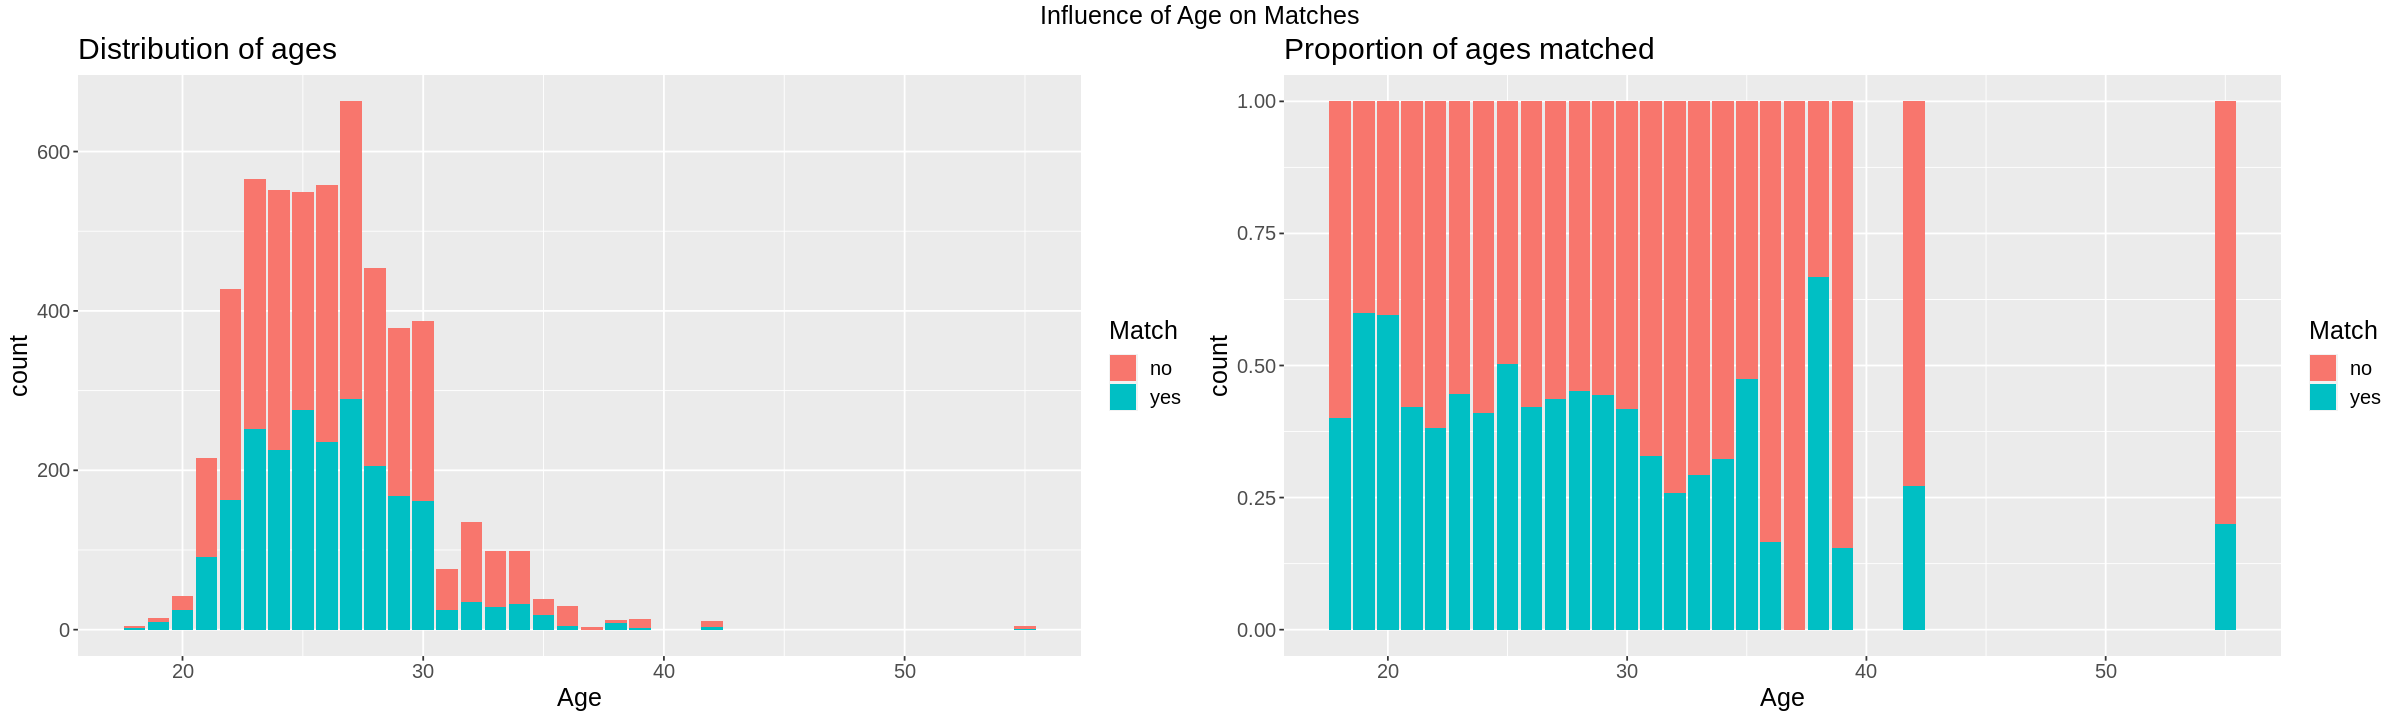

In [7]:
# Distribution of Ages
options(repr.plot.width=20, repr.plot.height=6)

age_distribution <- speed_dating_train |>
    ggplot(aes(x = age, fill = match)) + 
    geom_bar() + 
    labs(x = "Age", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Distribution of ages")

# Proportion of Ages
age_proportion <- speed_dating_train |>
    ggplot(aes(x = age, fill = match)) + 
    geom_bar(position = "fill") + 
    labs(x = "Age", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Proportion of ages matched")

grid.arrange(age_distribution, age_proportion,
             nrow = 1, top = textGrob("Influence of Age on Matches", gp=gpar(fontsize=15,font=8)))

In [8]:
# Plotting
options(repr.plot.width=25, repr.plot.height=6)

attractiveness_plot <- speed_dating_train |>
    ggplot(aes(x = attractiveness, fill = match)) + 
    labs(x = "Attractiveness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

sincerity_plot <- speed_dating_train |>
    ggplot(aes(x = sincerity, fill = match)) + 
    labs(x = "Sincerity", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

intelligence_plot <- speed_dating_train |>
    ggplot(aes(x = intelligence, fill = match))+ 
    labs(x = "Intelligence", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

funny_plot <- speed_dating_train |>
    ggplot(aes(x = funniness, fill = match)) + 
    labs(x = "Funniness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

ambition_plot <- speed_dating_train |>
    ggplot(aes(x = ambition, fill = match)) + 
    labs(x = "Ambition", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

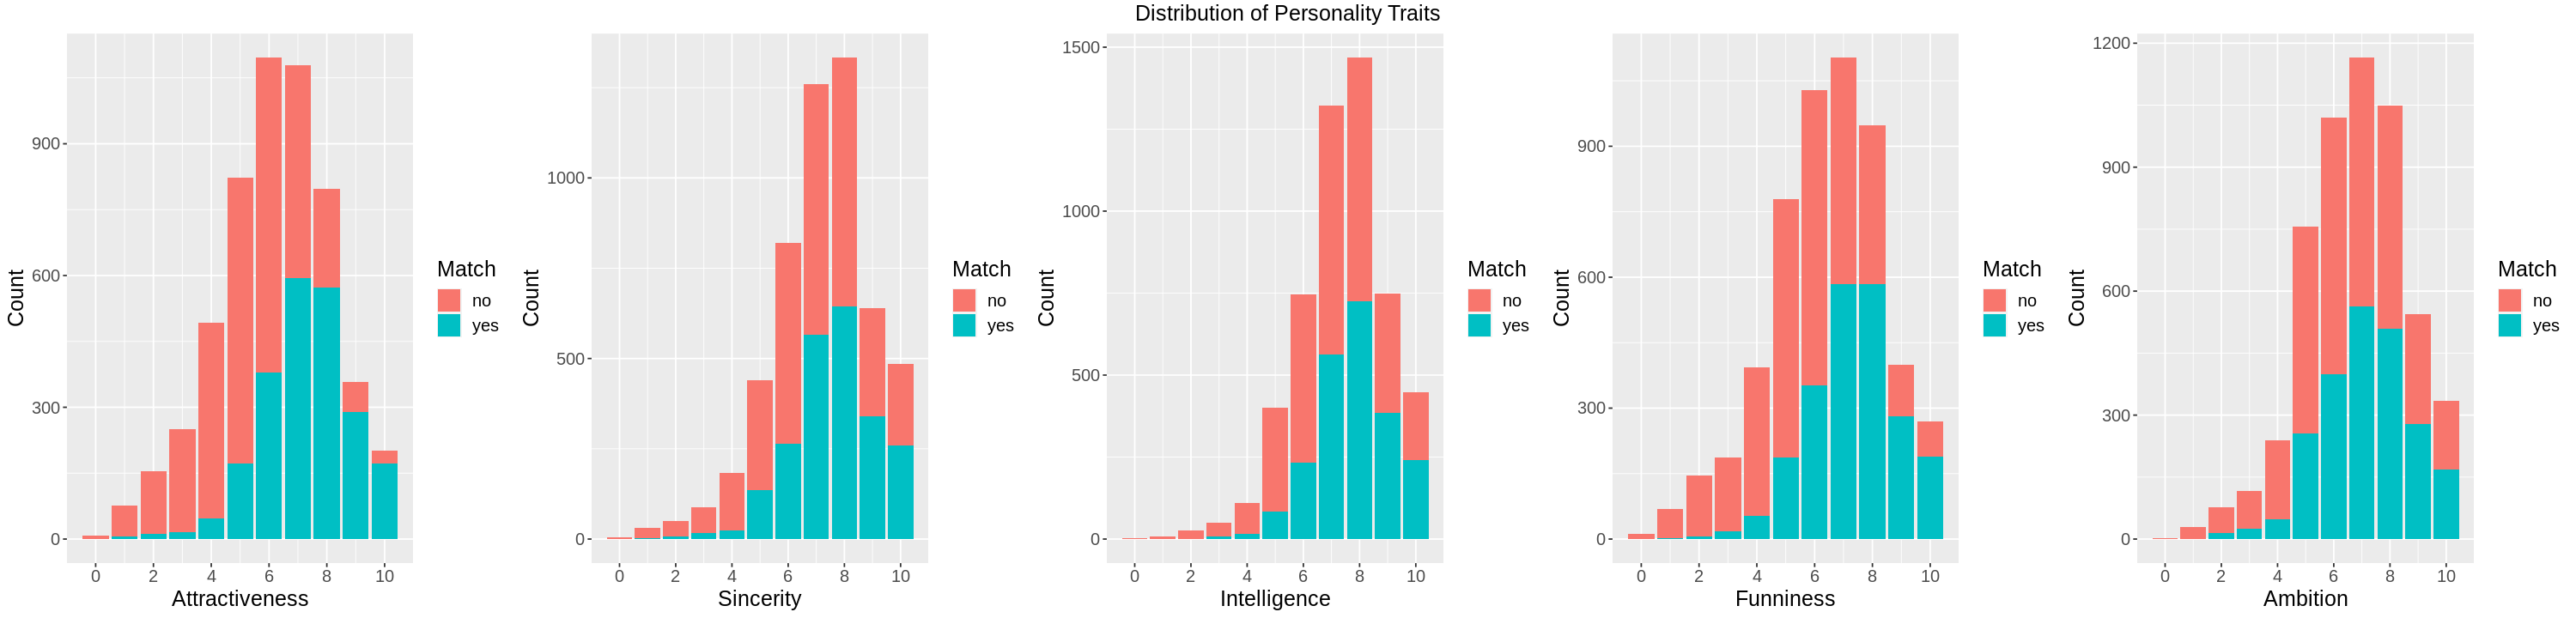

In [9]:
# Distributions of Personality Traits
attractiveness_dist <- attractiveness_plot +
    geom_bar()

sincerity_dist <- sincerity_plot +
    geom_bar()

intelligence_dist <- intelligence_plot +
    geom_bar()

funny_dist <- funny_plot +
    geom_bar()

ambition_dist <- ambition_plot +
    geom_bar()

grid.arrange(attractiveness_dist, sincerity_dist, intelligence_dist, funny_dist, ambition_dist, 
             nrow = 1, top = textGrob("Distribution of Personality Traits", gp=gpar(fontsize=15,font=8)))

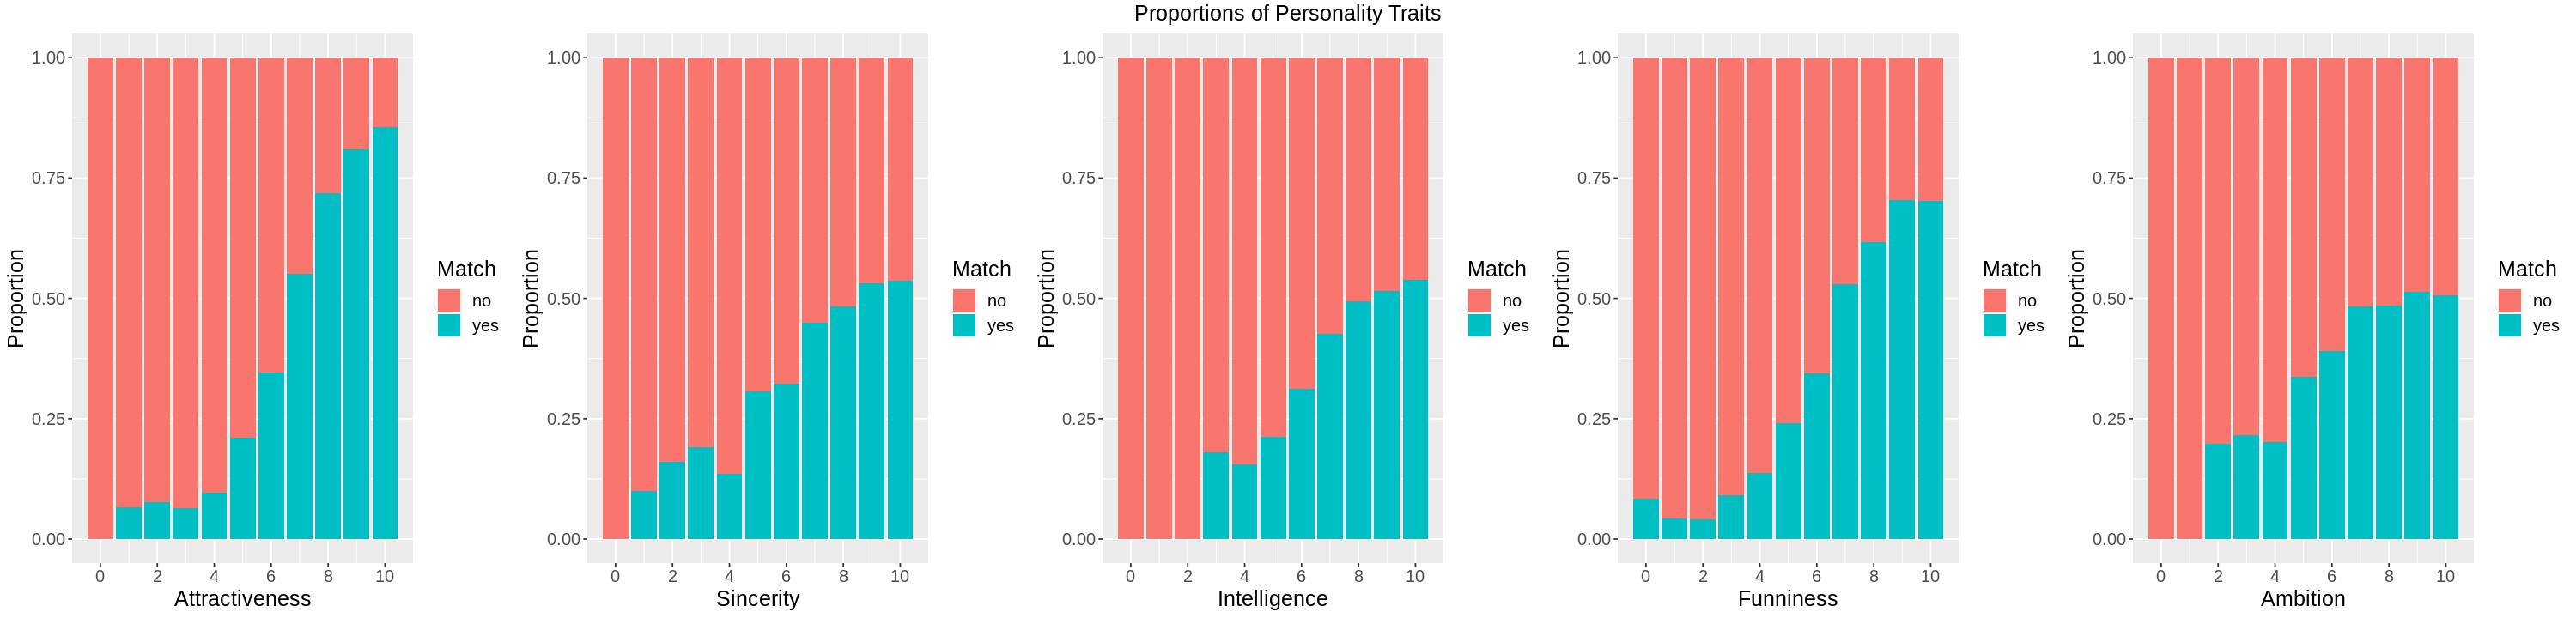

In [10]:
# Proportions of Personality Traits
attractiveness_proportion <- attractiveness_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

sincerity_proportion <- sincerity_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

intelligence_proportion <- intelligence_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

funny_proportion <- funny_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

ambition_proportion <- ambition_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

grid.arrange(attractiveness_proportion, sincerity_proportion, intelligence_proportion, funny_proportion, ambition_proportion, 
             nrow = 1, top = textGrob("Proportions of Personality Traits", gp=gpar(fontsize=15,font=8)))

### Methods

We analysed the distribution and proportion of ratings for each personality trait that we selected. Our first step was tidying the data, selecting and renaming the columns that we wanted to use, and filtering out any observations that had improper values. Afterwards, we split the dataset into a training and testing set, with proportions of 75% and 25%, respectively. By grouping and summarizing by the columns "match" and "gender", we were able to find the number of observations in each column, as well as the mean values of the personality trait ratings. From there, we created visualizations of the data by plotting bar graphs with the distributions and proportions of each personality trait. This gives us a clear image of which traits are most important to strengthen, in order to more likely match with a partner. 

Later in this project, we will use the classification method to predict whether a person will match or not. We will use the variables: age, attractiveness, sincerity, intelligence, funniness, and ambition, scaling and centering the data, since age is not on a scale of 0-10 like the other traits. 

### Expected Outcomes and Significance

From our visual analysis, we expect to find out which characteristics lead to a match in speed dating. Looking at the variables individually, we postulate that higher attraction, sincerity, intelligence, funniness and ambition should result in a higher probability of a match. Additionally, we expect that individuals that are younger are more likely to match, since older people are generally settled into long relationships already. 

These findings will be helpful for any industries or individuals who want to know what characteristics are most desired in a partner, whether it be for personal use, or industry use, for example, creating an algorithm for a dating app that can more efficiently match people together.

This project could raise these questions in the future:
- Is there a trend in what individual preferences result in a higher chance of a match?
- Can we predict which pairs of participants are likely to match based on their own preferences?
- How does the speed dating context influence date selection and relationship outcomes?


### References

- Department of Statistics, Columbia University. Dataset taken from: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/

###### 